Guide ITK: https://itk.org/ItkSoftwareGuide.pdf

In [1]:
import itk
print(itk.Version.GetITKVersion())

5.4.0


Guide VTK : https://vtk.org/wp-content/uploads/2021/08/VTKUsersGuide.pdf

In [2]:
import vtk
print(vtk.__version__)

9.3.0


In [3]:
import matplotlib.pyplot as plt

In [4]:
# renderWindowInteractor.SetInteractorStyle(vtk.vtkInteractorStyleImage())

### Image Registration

In [5]:
fixed_filepath = "./Data/case6_gre1.nrrd"
moving_filepath = "./Data/case6_gre2.nrrd"

In [6]:
PixelType = itk.ctype('unsigned short')
fixed_image = itk.imread(fixed_filepath, PixelType)
moving_image = itk.imread(moving_filepath, PixelType)

In [7]:
InputPixelType = itk.US
OutputPixelType = itk.F

InputImageType = itk.Image[InputPixelType, 3]
OutputImageType = itk.Image[OutputPixelType, 3]

In [8]:
CastFilterType = itk.CastImageFilter[InputImageType, OutputImageType]
castFilter = CastFilterType.New()
castFilter.SetInput(fixed_image)
castFilter.Update()
fixed_image_float = castFilter.GetOutput()

In [9]:
castFilter = CastFilterType.New()
castFilter.SetInput(moving_image)
castFilter.Update()
moving_image_float = castFilter.GetOutput()

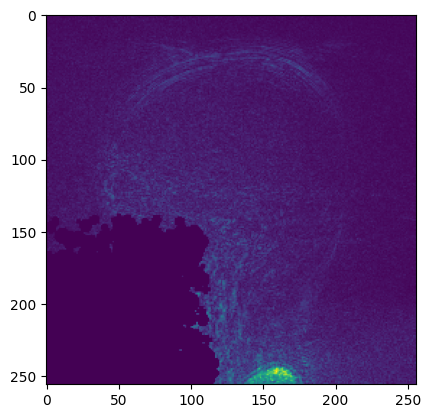

In [10]:
plt.imshow(fixed_image_float[0, :, :])

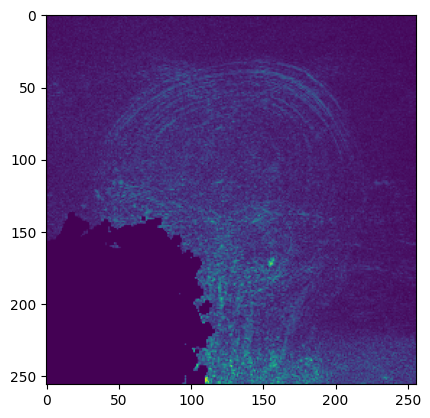

In [11]:
plt.imshow(moving_image_float[0, :, :])
# plt.imshow(moving_image_float[0, :, :] - fixed_image_float[0, :, :])

In [12]:
# NormalizeFilterType = itk.NormalizeImageFilter[InputImageType, OutputImageType]
# normalizeFilter = NormalizeFilterType.New()
# normalizeFilter.SetInputData(fixed_image)
# normalizeFilter.Update()

In [13]:
dimension = fixed_image_float.GetImageDimension()
FixedImageType = OutputImageType
MovingImageType = OutputImageType

In [14]:
TransformType = itk.AffineTransform[itk.D, 3]
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

optimizer.SetLearningRate(4)
optimizer.SetMinimumStepLength(0.001)
optimizer.SetNumberOfIterations(200)

metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()

Registration = itk.ImageRegistrationMethodv4[OutputImageType, OutputImageType]
registration = Registration.New(FixedImage=fixed_image_float, MovingImage=moving_image_float, Metric=metric,
                                                 Optimizer=optimizer, InitialTransform=initialTransform)

In [15]:
moving_initial_transform = TransformType.New()
initial_parameters = moving_initial_transform.GetParameters()
initial_parameters[0] = 0
initial_parameters[1] = 0
initial_parameters[2] = 0
moving_initial_transform.SetParameters(initial_parameters)

In [16]:
# Set the scales
scale_parameters = moving_initial_transform.GetParameters()
scale_parameters[0] = 1000
scale_parameters[1] = 1
scale_parameters[2] = 1
optimizer.SetScales(scale_parameters)

In [20]:
registration.SetMovingInitialTransform(moving_initial_transform)

# Set the center of the image
fixed_parameters = moving_initial_transform.GetFixedParameters()
fixed_parameters[0] = moving_image.GetLargestPossibleRegion().GetSize()[0] / 2.0
fixed_parameters[1] = moving_image.GetLargestPossibleRegion().GetSize()[1] / 2.0
# fixed_parameters[2] = moving_image.GetLargestPossibleRegion().GetSize()[2] / 2.0

moving_initial_transform.SetFixedParameters(fixed_parameters)

In [22]:
identity_transform = TransformType.New()
identity_transform.SetIdentity()
registration.SetFixedInitialTransform(identity_transform)
registration.SetNumberOfLevels(1)

In [23]:
registration.Update()

In [24]:
transform = registration.GetTransform()
final_parameters = transform.GetParameters()
angle = final_parameters.GetElement(0)
translation_along_x = final_parameters.GetElement(1)
translation_along_y = final_parameters.GetElement(2)
# translation_along_z = final_parameters.GetElement(3)

number_of_iterations = optimizer.GetCurrentIteration()

best_value = optimizer.GetValue()

print("Result = ")
print(" Angle = " + str(angle))
print(" Translation X = " + str(translation_along_x))
print(" Translation Y = " + str(translation_along_y))
# print(" Translation Z = " + str(translation_along_z))
print(" Iterations    = " + str(number_of_iterations))
print(" Metric value  = " + str(best_value))

Result = 
 Angle = nan
 Translation X = nan
 Translation Y = nan
 Iterations    = 200
 Metric value  = 1.7976931348623157e+308


In [ ]:
CompositeTransformType = itk.CompositeTransform[itk.D, dimension]
output_composite_transform = CompositeTransformType.New()
output_composite_transform.AddTransform(moving_initial_transform)
output_composite_transform.AddTransform(registration.GetModifiableTransform())

resampler = itk.ResampleImageFilter.New(Input=moving_image, Transform=transform, UseReferenceImage=True,
                                        ReferenceImage=fixed_image)
resampler.SetDefaultPixelValue(100)

subtraction = itk.SubtractImageFilter(Input1=fixed_image, Input2=resampler)
plt.ion()
plt.imshow(itk.GetArrayViewFromImage(subtraction))
plt.waitforbuttonpress()

OutputPixelType = itk.ctype('unsigned char')
OutputImageType = itk.Image[OutputPixelType, dimension]
caster = itk.CastImageFilter[FixedImageType, OutputImageType].New(resampler)

itk.imwrite(caster, output_filepath)

### Trying with 3D viewer

In [59]:
nrrdReader = vtk.vtkNrrdReader()
# nrrdReader.SetFileName("./Data/case6_gre1.nrrd")
nrrdReader.SetFileName("./Data/case6_gre2.nrrd")
nrrdReader.Update()

https://stackoverflow.com/a/56765160

In [60]:
# Calculate the center of the volume
nrrdReader.Update()
(xMin, xMax, yMin, yMax, zMin, zMax) = nrrdReader.GetExecutive().GetWholeExtent(nrrdReader.GetOutputInformation(0))
(xSpacing, ySpacing, zSpacing) = nrrdReader.GetOutput().GetSpacing()
(x0, y0, z0) = nrrdReader.GetOutput().GetOrigin()

center = [x0 + xSpacing * 0.5 * (xMin + xMax),
          y0 + ySpacing * 0.5 * (yMin + yMax),
          z0 + zSpacing * 0.5 * (zMin + zMax)]

In [61]:
# Matrices for axial, coronal, sagittal, oblique view orientations
axial = vtk.vtkMatrix4x4()
axial.DeepCopy((1, 0, 0, center[0],
                0, 1, 0, center[1],
                0, 0, 1, center[2],
                0, 0, 0, 1))

coronal = vtk.vtkMatrix4x4()
coronal.DeepCopy((1, 0, 0, center[0],
                  0, 0, 1, center[1],
                  0,-1, 0, center[2],
                  0, 0, 0, 1))

sagittal = vtk.vtkMatrix4x4()
sagittal.DeepCopy((0, 0,-1, center[0],
                   1, 0, 0, center[1],
                   0,-1, 0, center[2],
                   0, 0, 0, 1))

oblique = vtk.vtkMatrix4x4()
oblique.DeepCopy((1, 0, 0, center[0],
                  0, 0.866025, -0.5, center[1],
                  0, 0.5, 0.866025, center[2],
                  0, 0, 0, 1))

In [23]:
# Extract a slice in the desired orientation
reslice = vtk.vtkImageReslice()
# reslice.SetInputConnection(nrrdReader.GetOutputPort())
reslice.SetInputData(castFilter.GetOutput())
reslice.SetOutputDimensionality(2)
reslice.SetResliceAxes(axial) # Change view here (axial, sagittal, coronal)
reslice.SetInterpolationModeToLinear()

TypeError: SetInputData argument 1: method requires a VTK object

In [63]:
# Create a greyscale lookup table
table = vtk.vtkLookupTable()
table.SetRange(0, 2000) # image intensity range
table.SetValueRange(0.0, 1.0) # from black to white
table.SetSaturationRange(0.0, 0.0) # no color saturation
table.SetRampToLinear()
table.Build()

In [64]:
# Map the image through the lookup table
color = vtk.vtkImageMapToColors()
color.SetLookupTable(table)
color.SetInputConnection(reslice.GetOutputPort())

In [65]:
# Display the image
actor = vtk.vtkImageActor()
actor.GetMapper().SetInputConnection(color.GetOutputPort())

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)

window = vtk.vtkRenderWindow()
window.AddRenderer(renderer)

In [66]:
# Set up the interaction
interactorStyle = vtk.vtkInteractorStyleImage()
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetInteractorStyle(interactorStyle)
window.SetInteractor(interactor)
window.Render()

In [67]:
# Create callbacks for slicing the image
actions = {}
actions["Slicing"] = 0

def ButtonCallback(obj, event):
    if event == "LeftButtonPressEvent":
        actions["Slicing"] = 1
    else:
        actions["Slicing"] = 0

def MouseMoveCallback(obj, event):
    (lastX, lastY) = interactor.GetLastEventPosition()
    (mouseX, mouseY) = interactor.GetEventPosition()
    if actions["Slicing"] == 1:
        deltaY = mouseY - lastY
        reslice.Update()
        sliceSpacing = reslice.GetOutput().GetSpacing()[2]
        matrix = reslice.GetResliceAxes()
        # move the center point that we are slicing through
        center = matrix.MultiplyPoint((0, 0, sliceSpacing*deltaY, 1))
        matrix.SetElement(0, 3, center[0])
        matrix.SetElement(1, 3, center[1])
        matrix.SetElement(2, 3, center[2])
        window.Render()
    else:
        interactorStyle.OnMouseMove()


interactorStyle.AddObserver("MouseMoveEvent", MouseMoveCallback)
interactorStyle.AddObserver("LeftButtonPressEvent", ButtonCallback)
interactorStyle.AddObserver("LeftButtonReleaseEvent", ButtonCallback)

6

In [68]:
# Start interaction
interactor.Start()
del renderer
del window
del interactor

### Tests

In [31]:
Dimension = 3;
PixelType = itk.ctype('float');
 
FixedImageType = itk.Image[PixelType, Dimension]
MovingImageType = itk.Image[PixelType, Dimension]

TransformType = itk.AffineTransform[itk.D, Dimension]

In [32]:
OptimizerType = itk.RegularStepGradientDescentOptimizerv4[itk.D]
MetricType = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType]
RegistrationType = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType, TransformType]
 
metric = MetricType.New()
optimizer = OptimizerType.New()
registration = RegistrationType.New()
 
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)

TemplateTypeError: itk.ImageRegistrationMethodv4 is not wrapped for input type `itk.Image[itk.F,3], itk.Image[itk.F,3], itk.AffineTransform[itk.D,3]`.

To limit the size of the package, only a limited number of
types are available in ITK Python. To print the supported
types, run the following command in your python environment:

    itk.ImageRegistrationMethodv4.GetTypes()

Possible solutions:
* If you are an application user:
** Convert your input image into a supported format (see below).
** Contact developer to report the issue.
* If you are an application developer, force input images to be
loaded in a supported pixel type.

    e.g.: instance = itk.ImageRegistrationMethodv4[itk.Image[itk.F,2], itk.Image[itk.F,2]].New(my_input)

* (Advanced) If you are an application developer, build ITK Python yourself and
turned to `ON` the corresponding CMake option to wrap the pixel type or image
dimension you need. When configuring ITK with CMake, you can set
`ITK_WRAP_${type}` (replace ${type} with appropriate pixel type such as
`double`). If you need to support images with 4 or 5 dimensions, you can add
these dimensions to the list of dimensions in the CMake variable
`ITK_WRAP_IMAGE_DIMS`.

Supported input types:

itk.Image[itk.F,2]
itk.Image[itk.F,2]
itk.Image[itk.F,2]
itk.Image[itk.F,2]
itk.Image[itk.F,2]
itk.Image[itk.F,2]
itk.Image[itk.F,2]
itk.Image[itk.D,2]
itk.Image[itk.D,2]
itk.Image[itk.D,2]
itk.Image[itk.D,2]
itk.Image[itk.D,2]
itk.Image[itk.D,2]
itk.Image[itk.D,2]
itk.Image[itk.F,3]
itk.Image[itk.F,3]
itk.Image[itk.F,3]
itk.Image[itk.F,3]
itk.Image[itk.F,3]
itk.Image[itk.F,3]
itk.Image[itk.F,3]
itk.Image[itk.D,3]
itk.Image[itk.D,3]
itk.Image[itk.D,3]
itk.Image[itk.D,3]
itk.Image[itk.D,3]
itk.Image[itk.D,3]
itk.Image[itk.D,3]
itk.Image[itk.F,4]
itk.Image[itk.F,4]
itk.Image[itk.F,4]
itk.Image[itk.F,4]
itk.Image[itk.F,4]
itk.Image[itk.F,4]
itk.Image[itk.F,4]
itk.Image[itk.D,4]
itk.Image[itk.D,4]
itk.Image[itk.D,4]
itk.Image[itk.D,4]
itk.Image[itk.D,4]
itk.Image[itk.D,4]
itk.Image[itk.D,4]


In [33]:
    itk.ImageRegistrationMethodv4.GetTypes()

<itkTemplate itk::ImageRegistrationMethodv4>
Options:
  [<class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkImagePython.itkImageD2'>]
  [<class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkBSplineSmoothingOnUpdateDisplacementFieldTransformPython.itkBSplineSmoothingOnUpdateDisplacementFieldTransformD2'>]
  [<class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkDisplacementFieldTransformPython.itkDisplacementFieldTransformD2'>]
  [<class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkDisplacementFieldTransformPython.itkDisplacementFieldTransformD2'>, <class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkMeshBasePython.itkMeshD2'>]
  [<class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkImagePython.itkImageD2'>, <class 'itk.itkGaussianSmoothingOnUpdateTimeVaryingVelocityFieldTransformPython.itkGaussianSmoothingOnUpdateTimeVaryingVelocityFieldTransfor

In [ ]:

  auto transform = TransformType::New();
 
 
  using FixedImageReaderType = itk::ImageFileReader<FixedImageType>;
  using MovingImageReaderType = itk::ImageFileReader<MovingImageType>;
  auto fixedImageReader = FixedImageReaderType::New();
  auto movingImageReader = MovingImageReaderType::New();
  fixedImageReader->SetFileName(argv[1]);
  movingImageReader->SetFileName(argv[2]);
 
 
  registration->SetFixedImage(fixedImageReader->GetOutput());
  registration->SetMovingImage(movingImageReader->GetOutput());
 
 
  //  Software Guide : BeginLatex
  //
  //  In this example, we again use the
  //  \doxygen{CenteredTransformInitializer} helper class in order to compute
  //  reasonable values for the initial center of rotation and the
  //  translations. The initializer is set to use the center of mass of each
  //  image as the initial correspondence correction.
  //
  //  Software Guide : EndLatex
 
  // Software Guide : BeginCodeSnippet
  using TransformInitializerType =
    itk::CenteredTransformInitializer<TransformType,
                                      FixedImageType,
                                      MovingImageType>;
  auto initializer = TransformInitializerType::New();
  initializer->SetTransform(transform);
  initializer->SetFixedImage(fixedImageReader->GetOutput());
  initializer->SetMovingImage(movingImageReader->GetOutput());
  initializer->MomentsOn();
  initializer->InitializeTransform();
  // Software Guide : EndCodeSnippet
 
 
  //  Software Guide : BeginLatex
  //
  //  Now we pass the transform object to the registration filter, and it will
  //  be grafted to the output transform of the registration filter by
  //  updating its parameters during the the registration process.
  //
  //  Software Guide : EndLatex
 
  // Software Guide : BeginCodeSnippet
  registration->SetInitialTransform(transform);
  registration->InPlaceOn();
  // Software Guide : EndCodeSnippet
 
 
  //  Software Guide : BeginLatex
  //
  //  Keeping in mind that the scale of units in scaling, rotation and
  //  translation are quite different, we take advantage of the scaling
  //  functionality provided by the optimizers. We know that the first $N
  //  \times N$ elements of the parameters array correspond to the rotation
  //  matrix factor, and the last $N$ are the components of the translation to
  //  be applied after multiplication with the matrix is performed.
  //
  //  Software Guide : EndLatex
 
 
  double translationScale = 1.0 / 1000.0;
 
  if (argc > 8)
  {
    translationScale = std::stod(argv[8]);
  }
 
 
  // Software Guide : BeginCodeSnippet
  using OptimizerScalesType = OptimizerType::ScalesType;
  OptimizerScalesType optimizerScales(transform->GetNumberOfParameters());
 
  optimizerScales[0] = 1.0;
  optimizerScales[1] = 1.0;
  optimizerScales[2] = 1.0;
  optimizerScales[3] = 1.0;
  optimizerScales[4] = translationScale;
  optimizerScales[5] = translationScale;
 
  optimizer->SetScales(optimizerScales);
  // Software Guide : EndCodeSnippet
 
 
  //  Software Guide : BeginLatex
  //
  //  We also set the usual parameters of the optimization method. In this
  //  case we are using an
  //  \doxygen{RegularStepGradientDescentOptimizerv4} as before. Below, we
  //  define the optimization parameters like learning rate (initial step
  //  length), minimum step length and number of iterations. These last two
  //  act as stopping criteria for the optimization.
  //
  //  Software Guide : EndLatex
 
  double steplength = 1.0;
 
  if (argc > 6)
  {
    steplength = std::stod(argv[6]);
  }
 
 
  unsigned int maxNumberOfIterations = 300;
 
  if (argc > 7)
  {
    maxNumberOfIterations = std::stoi(argv[7]);
  }
 
 
  // Software Guide : BeginCodeSnippet
  optimizer->SetLearningRate(steplength);
  optimizer->SetMinimumStepLength(0.0001);
  optimizer->SetNumberOfIterations(maxNumberOfIterations);
  // Software Guide : EndCodeSnippet
 
 
  // Create the Command observer and register it with the optimizer.
  //
  auto observer = CommandIterationUpdate::New();
  optimizer->AddObserver(itk::IterationEvent(), observer);
 
 
  // One level registration process without shrinking and smoothing.
  //
  constexpr unsigned int numberOfLevels = 1;
 
  RegistrationType::ShrinkFactorsArrayType shrinkFactorsPerLevel;
  shrinkFactorsPerLevel.SetSize(1);
  shrinkFactorsPerLevel[0] = 1;
 
  RegistrationType::SmoothingSigmasArrayType smoothingSigmasPerLevel;
  smoothingSigmasPerLevel.SetSize(1);
  smoothingSigmasPerLevel[0] = 0;
 
  registration->SetNumberOfLevels(numberOfLevels);
  registration->SetSmoothingSigmasPerLevel(smoothingSigmasPerLevel);
  registration->SetShrinkFactorsPerLevel(shrinkFactorsPerLevel);
 
 
  //  Software Guide : BeginLatex
  //
  //  Finally we trigger the execution of the registration method by calling
  //  the \code{Update()} method. The call is placed in a \code{try/catch}
  //  block in the case any exceptions are thrown.
  //
  //  Software Guide : EndLatex
 
  // Software Guide : BeginCodeSnippet
  try
  {
    registration->Update();
    std::cout << "Optimizer stop condition: "
              << registration->GetOptimizer()->GetStopConditionDescription()
              << std::endl;
  }
  catch (const itk::ExceptionObject & err)
  {
    std::cerr << "ExceptionObject caught !" << std::endl;
    std::cerr << err << std::endl;
    return EXIT_FAILURE;
  }
  // Software Guide : EndCodeSnippet
 
 
  //  Software Guide : BeginLatex
  //
  //  Once the optimization converges, we recover the parameters from the
  //  registration method. We can also recover the
  //  final value of the metric with the \code{GetValue()} method and the
  //  final number of iterations with the \code{GetCurrentIteration()}
  //  method.
  //
  //  \index{itk::RegistrationMethodv4!GetValue()}
  //  \index{itk::RegistrationMethodv4!GetCurrentIteration()}
  //
  //  Software Guide : EndLatex
 
  // Software Guide : BeginCodeSnippet
  const TransformType::ParametersType finalParameters =
    registration->GetOutput()->Get()->GetParameters();
 
  const double finalRotationCenterX = transform->GetCenter()[0];
  const double finalRotationCenterY = transform->GetCenter()[1];
  const double finalTranslationX = finalParameters[4];
  const double finalTranslationY = finalParameters[5];
 
  const unsigned int numberOfIterations = optimizer->GetCurrentIteration();
  const double       bestValue = optimizer->GetValue();
  // Software Guide : EndCodeSnippet
 
 
  // Print out results
  //
  std::cout << "Result = " << std::endl;
  std::cout << " Center X      = " << finalRotationCenterX << std::endl;
  std::cout << " Center Y      = " << finalRotationCenterY << std::endl;
  std::cout << " Translation X = " << finalTranslationX << std::endl;
  std::cout << " Translation Y = " << finalTranslationY << std::endl;
  std::cout << " Iterations    = " << numberOfIterations << std::endl;
  std::cout << " Metric value  = " << bestValue << std::endl;
 
  // Compute the rotation angle and scaling from SVD of the matrix
  // \todo Find a way to figure out if the scales are along X or along Y.
  // VNL returns the eigenvalues ordered from largest to smallest.
 
  vnl_matrix<double> p(2, 2);
  p[0][0] = static_cast<double>(finalParameters[0]);
  p[0][1] = static_cast<double>(finalParameters[1]);
  p[1][0] = static_cast<double>(finalParameters[2]);
  p[1][1] = static_cast<double>(finalParameters[3]);
  vnl_svd<double>    svd(p);
  vnl_matrix<double> r(2, 2);
  r = svd.U() * vnl_transpose(svd.V());
  double angle = std::asin(r[1][0]);
 
  const double angleInDegrees = angle * 180.0 / itk::Math::pi;
 
  std::cout << " Scale 1         = " << svd.W(0) << std::endl;
  std::cout << " Scale 2         = " << svd.W(1) << std::endl;
  std::cout << " Angle (degrees) = " << angleInDegrees << std::endl;
 
 
  //  Software Guide : BeginLatex
  //
  //  Let's execute this example over two of the images provided in
  //  \code{Examples/Data}:
  //
  //  \begin{itemize}
  //  \item \code{BrainProtonDensitySliceBorder20.png}
  //  \item \code{BrainProtonDensitySliceR10X13Y17.png}
  //  \end{itemize}
  //
  //  The second image is the result of intentionally rotating the first
  //  image by $10$ degrees and then translating by $(-13,-17)$.  Both images
  //  have unit-spacing and are shown in Figure
  //  ???. We execute the code using the
  //  following parameters: step length=1.0, translation scale= 0.0001 and
  //  maximum number of iterations = 300. With these images and parameters
  //  the registration takes $92$ iterations and produces
  //
  //  \begin{center}
  //  \begin{verbatim}
  //   90  44.0851 [0.9849, -0.1729, 0.1725, 0.9848, 12.4541, 16.0759]
  //   AffineAngle: 9.9494
  //  \end{verbatim}
  //  \end{center}
  //
  //  These results are interpreted as
  //
  //  \begin{itemize}
  //  \item Iterations   = 92
  //  \item Final Metric = 44.0386
  //  \item Center       = $( 111.204,   131.591   )$ millimeters
  //  \item Translation  = $(   12.4542,  16.076 )$ millimeters
  //  \item Affine scales = $(1.00014, .999732)$
  //  \end{itemize}
  //
  //  The second component of the matrix values is usually associated with
  //  $\sin{\theta}$. We obtain the rotation through SVD of the affine
  //  matrix. The value is $9.9494$ degrees, which is approximately the
  //  intentional misalignment of $10.0$ degrees.
  //
  // \begin{figure}
  // \center
  // \includegraphics[width=0.44\textwidth]{BrainProtonDensitySliceBorder20}
  // \includegraphics[width=0.44\textwidth]{BrainProtonDensitySliceR10X13Y17}
  // \itkcaption[AffineTransform registration]{Fixed and moving images
  // provided as input to the registration method using the AffineTransform.}
  // \label{fig:FixedMovingImageRegistration9}
  // \end{figure}
  //
  //
  // \begin{figure}
  // \center
  // \includegraphics[width=0.32\textwidth]{ImageRegistration9Output}
  // \includegraphics[width=0.32\textwidth]{ImageRegistration9DifferenceBefore}
  // \includegraphics[width=0.32\textwidth]{ImageRegistration9DifferenceAfter}
  // \itkcaption[AffineTransform output images]{The resampled moving image
  // (left), and the difference between the fixed and moving images before
  // (center) and after (right) registration with the AffineTransform
  // transform.} \label{fig:ImageRegistration9Outputs} \end{figure}
  //
  // Figure ??? shows the output of the
  // registration. The right most image of this figure shows the squared
  // magnitude difference between the fixed image and the resampled
  // moving image.
  //
  // \begin{figure}
  // \center
  // \includegraphics[height=0.32\textwidth]{ImageRegistration9TraceMetric}
  // \includegraphics[height=0.32\textwidth]{ImageRegistration9TraceAngle}
  // \includegraphics[height=0.32\textwidth]{ImageRegistration9TraceTranslations}
  // \itkcaption[AffineTransform output plots]{Metric values,
  // rotation angle and translations during the registration using the
  // AffineTransform transform.}
  // \label{fig:ImageRegistration9Plots}
  // \end{figure}
  //
  //  Figure ??? shows the plots of the main
  //  output parameters of the registration process. The metric values at
  //  every iteration are shown on the left plot. The angle values are shown
  //  on the middle plot, while the translation components of the registration
  //  are presented on the right plot. Note that the final total offset of the
  //  transform is to be computed as a combination of the shift due to
  //  rotation plus the explicit translation set on the transform.
  //
  //  Software Guide : EndLatex
 
 
  //  The following code is used to dump output images to files.
  //  They illustrate the final results of the registration.
  //  We will resample the moving image and write out the difference image
  //  before and after registration. We will also rescale the intensities of
  //  the difference images, so that they look better!
  using ResampleFilterType =
    itk::ResampleImageFilter<MovingImageType, FixedImageType>;
 
  auto resampler = ResampleFilterType::New();
 
  resampler->SetTransform(transform);
  resampler->SetInput(movingImageReader->GetOutput());
 
  FixedImageType::Pointer fixedImage = fixedImageReader->GetOutput();
 
  resampler->SetSize(fixedImage->GetLargestPossibleRegion().GetSize());
  resampler->SetOutputOrigin(fixedImage->GetOrigin());
  resampler->SetOutputSpacing(fixedImage->GetSpacing());
  resampler->SetOutputDirection(fixedImage->GetDirection());
  resampler->SetDefaultPixelValue(100);
 
  using OutputPixelType = unsigned char;
 
  using OutputImageType = itk::Image<OutputPixelType, Dimension>;
 
  using CastFilterType =
    itk::CastImageFilter<FixedImageType, OutputImageType>;
 
  using WriterType = itk::ImageFileWriter<OutputImageType>;
 
 
  auto writer = WriterType::New();
  auto caster = CastFilterType::New();
 
 
  writer->SetFileName(argv[3]);
 
 
  caster->SetInput(resampler->GetOutput());
  writer->SetInput(caster->GetOutput());
  writer->Update();
 
 
  using DifferenceFilterType =
    itk::SubtractImageFilter<FixedImageType, FixedImageType, FixedImageType>;
 
  auto difference = DifferenceFilterType::New();
 
  difference->SetInput1(fixedImageReader->GetOutput());
  difference->SetInput2(resampler->GetOutput());
 
  auto writer2 = WriterType::New();
 
  using RescalerType =
    itk::RescaleIntensityImageFilter<FixedImageType, OutputImageType>;
 
  auto intensityRescaler = RescalerType::New();
 
  intensityRescaler->SetInput(difference->GetOutput());
  intensityRescaler->SetOutputMinimum(0);
  intensityRescaler->SetOutputMaximum(255);
 
  writer2->SetInput(intensityRescaler->GetOutput());
  resampler->SetDefaultPixelValue(1);
 
  // Compute the difference image between the
  // fixed and resampled moving image.
  if (argc > 5)
  {
    writer2->SetFileName(argv[5]);
    writer2->Update();
  }
 
 
  using IdentityTransformType = itk::IdentityTransform<double, Dimension>;
  auto identity = IdentityTransformType::New();
 
  // Compute the difference image between the
  // fixed and moving image before registration.
  if (argc > 4)
  {
    resampler->SetTransform(identity);
    writer2->SetFileName(argv[4]);
    writer2->Update();
  }
 
  return EXIT_SUCCESS;
}